# Data creation and saving in `OceanTurb.jl`

Here we demonstrate how to save model output in `OceanTurb.jl`.

To start, we set up our environment and define a few convenient plotting functions.

In [1]:
using Pkg

try
    using JLD2
catch
    Pkg.activate("")
    warn("Adding JLD2 to your base Julia environment!")
    Pkg.add("JLD2")
end

# Activate OceanTurb environment
Pkg.activate("..")
Pkg.instantiate()
using OceanTurb, Printf
    
@use_pyplot_utils

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


For this example we use the same "simple flux" scenario used in `kpp_examples.ipynb`.

In [2]:
function simple_flux_model(; N=10, L=100, Tz=0.01, Fb=1e-8, Fu=0, parameters=KPP.Parameters())
    
    model = KPP.Model(N=N, L=L, parameters=parameters, stepper=:BackwardEuler)

    # Initial condition
    T₀(z) = 20 + Tz*z
    
    # Set T to the function T0(z)
    model.solution.T = T₀

    # Fluxes
    Fθ = Fb / (model.constants.α * model.constants.g)
    model.bcs.U.top = FluxBoundaryCondition(Fu)
    model.bcs.T.top = FluxBoundaryCondition(Fθ)
    model.bcs.T.bottom = GradientBoundaryCondition(Tz)
    
    return model
end

simple_flux_model (generic function with 1 method)

# Saving data

To facilitate data, we define a few functions that save useful things both on model initialization (`init_data`), and while the model is running (`save_data`).

We use `JLD2.jl`.

In [3]:
function save_data(path, model)
    iteration = iter(model)
    jldopen(path, "a+") do file
        file["timeseries/t/$iteration"] = time(model)
        file["timeseries/U/$iteration"] = collect(data(model.solution.U))
        file["timeseries/T/$iteration"] = collect(data(model.solution.T))
    end
end

function init_data(path, model)
    Fu = OceanTurb.getbc(model, model.bcs.U.top)
    Fb = OceanTurb.getbc(model, model.bcs.T.top) * model.constants.α * model.constants.g
    Tz = OceanTurb.getbc(model, model.bcs.T.bottom)
    
    jldopen(path, "a+") do file
        for gridfield in (:N, :L)
            file["grid/$gridfield"] = getproperty(model.grid, gridfield)
        end

        file["bcs/Fu"] = Fu
        file["bcs/Fb"] = Fb
        file["bcs/Tz"] = Tz
    end

    return nothing
end

init_data (generic function with 1 method)

Next, we generate a model with some benign parameters and run, saving data every `dout` seconds.

In [4]:
    dt = 10 # time step in seconds
  dout = 10*minute # interval between output
tfinal = 4*hour # final time

ntot = Int(tfinal/dt)

nint = Int(dout/dt)
nout = Int(ntot/nint)

filepath = joinpath(".", "test_free_convection.jld2")

model = simple_flux_model(
     N = 100, 
     L = 100, 
    Tz = 4.08e-4, 
    Fb = 5e-8, 
    Fu = 0
)

isfile(filepath) && rm(filepath)
init_data(filepath, model)

for i = 1:nout
    @printf "\nrunning from iter %d" iter(model)
    @time iterate!(model, dt, nint)
        
    @printf "    ...saving at iter %d" iter(model)
    @time save_data(filepath, model)
end


running from iter 0  0.693966 seconds (1.78 M allocations: 77.551 MiB, 4.27% gc time)
    ...saving at iter 60  0.499681 seconds (965.92 k allocations: 48.710 MiB, 5.12% gc time)

running from iter 60  0.025822 seconds (300.85 k allocations: 4.605 MiB)
    ...saving at iter 120  0.001298 seconds (277 allocations: 22.141 KiB)

running from iter 120  0.024398 seconds (303.68 k allocations: 4.648 MiB)
    ...saving at iter 180  0.001902 seconds (283 allocations: 22.516 KiB)

running from iter 180  0.023018 seconds (305.88 k allocations: 4.682 MiB)
    ...saving at iter 240  0.001164 seconds (289 allocations: 22.891 KiB)

running from iter 240  0.027139 seconds (307.62 k allocations: 4.709 MiB, 19.80% gc time)
    ...saving at iter 300  0.001042 seconds (295 allocations: 23.266 KiB)

running from iter 300  0.019340 seconds (309.11 k allocations: 4.731 MiB)
    ...saving at iter 360  0.001111 seconds (307 allocations: 24.109 KiB)

running from iter 360  0.019850 seconds (310.48 k allocatio

# Opening and analyzing data

Running the model created a jld file, which we can open and look at:

In [5]:
file = jldopen(filepath, "r")

@show file

N = file["grid/N"]
L = file["grid/L"]
@show iters = parse.(Int, keys(file["timeseries/t"]))

close(file)

file = JLDFile /Users/gregorywagner/Projects/OceanTurb.jl/examples/test_free_convection.jld2 (read-only)
 ├─📂 grid
 │  ├─🔢 N
 │  └─🔢 L
 ├─📂 bcs
 │  ├─🔢 Fu
 │  ├─🔢 Fb
 │  └─🔢 Tz
 └─📂 timeseries
    ├─📂 t
    │  ├─🔢 60
    │  ├─🔢 120
    │  ├─🔢 180
    │  ├─🔢 240
    │  ├─🔢 300
    │  ├─🔢 360
    │  ├─🔢 420
    │  ├─🔢 480
    │  ├─🔢 540
    │  ├─🔢 600
    │  ├─🔢 660
    │  ├─🔢 720
    │  ├─🔢 780
    │  ├─🔢 840
    │  ├─🔢 900
    │  ├─🔢 960
    │  ├─🔢 1020
    │  ├─🔢 1080
    │  ├─🔢 1140
    │  ├─🔢 1200
    │  ├─🔢 1260
    │  ├─🔢 1320
    │  ├─🔢 1380
    │  └─🔢 1440
    ├─📂 U
    │  ├─🔢 60
    │  ├─🔢 120
    │  ├─🔢 180
    │  ├─🔢 240
    │  ├─🔢 300
    │  ├─🔢 360
    │  ├─🔢 420
    │  ├─🔢 480
    │  ├─🔢 540
    │  ├─🔢 600
    │  ├─🔢 660
    │  ├─🔢 720
    │  ├─🔢 780
    │  ├─🔢 840
    │  ├─🔢 900
    │  ├─🔢 960
    │  ├─🔢 1020
    │  ├─🔢 1080
    │  ├─🔢 1140
    │  ├─🔢 1200
    │  ├─🔢 1260
    │  ├─🔢 1320
    │  ├─🔢 1380
    │  └─🔢 1440
    └─📂 T
       ├─🔢 60
       ├─🔢 120
       ├─🔢 180

# Plotting data

Now we can plot the data (and otherwise analyze it if we wish).

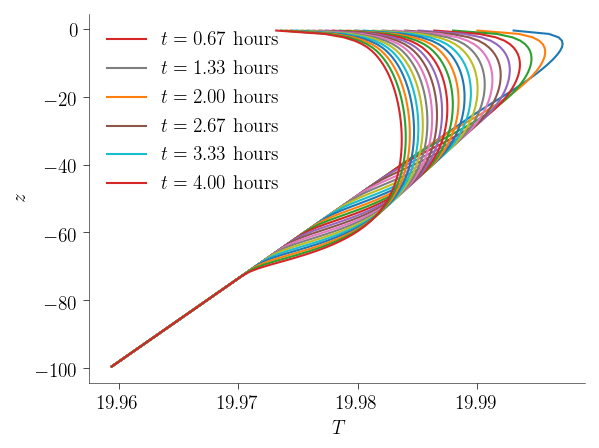

PyObject <matplotlib.legend.Legend object at 0x140b62be0>

In [6]:
grid = UniformGrid(N, L)

function get_t_and_T(path, i)
    file = jldopen(path, "r")
    t = file["timeseries/t/$i"]
    T = file["timeseries/T/$i"]
    close(file)
    t, T
end

fig, axs = subplots()
cornerspines()
xlabel(L"T")
ylabel(L"z")

for (ii, iter) in enumerate(iters)
    t, T = get_t_and_T(filepath, iter)
    plotlabel = ii % 4 == 0 ? @sprintf("\$ t = %.2f \$ hours", t/hour) : ""
    plot(T, grid.zc, label=plotlabel)
end

legend()